### Modelos

In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight

# Cargar los datos
df = pd.read_excel("Base_Limpia.xlsx")

# Manejo de fechas (calculando edad)
df['estu_fechanacimiento'] = pd.to_datetime(df['estu_fechanacimiento'], errors='coerce', format='%d/%m/%y')
df = df[df['estu_fechanacimiento'].notna()]

# Convertir el periodo a fecha (primer día del mes)
def periodo_a_fecha(periodo):
    periodo_str = str(periodo)
    anio = int(periodo_str[:4])
    mes = int(periodo_str[4:])
    return datetime(anio, mes, 1)

df['fecha_examen'] = df['periodo'].apply(periodo_a_fecha)

# Calcular la edad al momento del examen
from dateutil.relativedelta import relativedelta
df['edad_examen'] = df.apply(lambda row: relativedelta(row['fecha_examen'], row['estu_fechanacimiento']).years, axis=1)

# Selección de columnas
categorical_columns = [
    'cole_area_ubicacion', 'cole_caracter', 'cole_bilingue', 'cole_jornada',
    'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora', 'fami_tieneautomovil','fami_estratovivienda','fami_personashogar'
]

numerical_columns = [
    'edad_examen'
]

# Manejar valores faltantes
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

# Codificar variables categóricas
encoder = OrdinalEncoder()
df[categorical_columns] = encoder.fit_transform(df[categorical_columns])

# Normalizar variables numéricas
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Preparar las variables predictoras y la variable objetivo
X = df[categorical_columns + numerical_columns]
y = (df['punt_global'] >= 300).astype(int)  # Variable objetivo binaria

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [105]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos de las clases para tratar el desbalance de clases
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights_dict = dict(zip(unique_classes, class_weights))

# Mostrar los pesos de clase
print(f"Pesos de clase: {class_weights_dict}")

Pesos de clase: {0: 0.5614200905310268, 1: 4.5703293961071365}


### Modelo de Clasificación - Escogido

Epoch 1/30


/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3435/3435 - 2s - 621us/step - accuracy: 0.8978 - loss: 0.2857 - val_accuracy: 0.9000 - val_loss: 0.2751
Epoch 2/30
3435/3435 - 1s - 430us/step - accuracy: 0.8997 - loss: 0.2767 - val_accuracy: 0.9004 - val_loss: 0.2759
Epoch 3/30
3435/3435 - 1s - 429us/step - accuracy: 0.8997 - loss: 0.2748 - val_accuracy: 0.9003 - val_loss: 0.2797
Epoch 4/30
3435/3435 - 2s - 453us/step - accuracy: 0.8999 - loss: 0.2734 - val_accuracy: 0.9000 - val_loss: 0.2740
Epoch 5/30
3435/3435 - 2s - 446us/step - accuracy: 0.9001 - loss: 0.2725 - val_accuracy: 0.9007 - val_loss: 0.2691
Epoch 6/30
3435/3435 - 2s - 483us/step - accuracy: 0.9001 - loss: 0.2718 - val_accuracy: 0.9003 - val_loss: 0.2707
Epoch 7/30
3435/3435 - 2s - 458us/step - accuracy: 0.9005 - loss: 0.2713 - val_accuracy: 0.9009 - val_loss: 0.2697
Epoch 8/30
3435/3435 - 2s - 510us/step - accuracy: 0.9006 - loss: 0.2706 - val_accuracy: 0.9009 - val_loss: 0.2688
Epoch 9/30
3435/3435 - 2s - 451us/step - accuracy: 0.9005 - loss: 0.2704 - val_accuracy: 0.

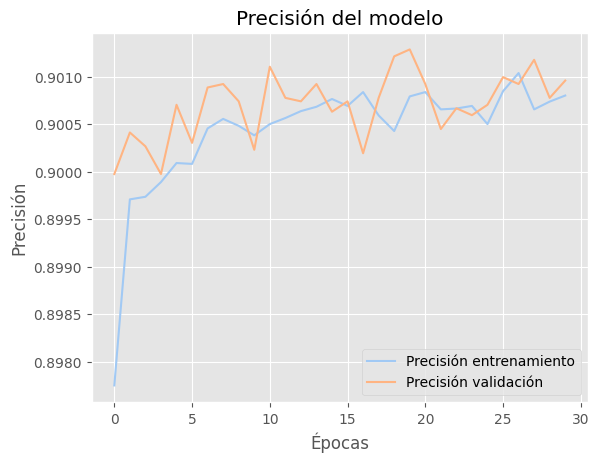

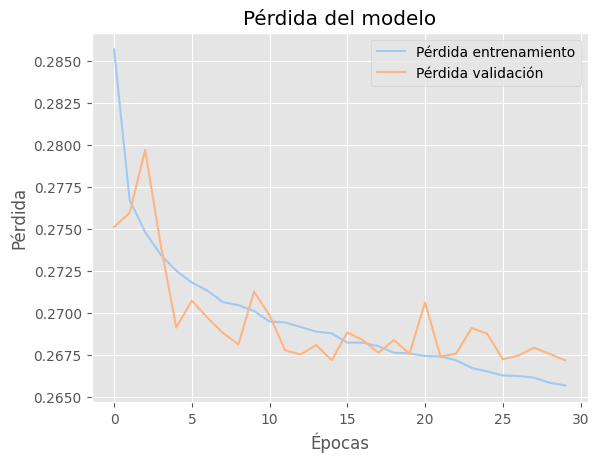

In [106]:
# Crear el modelo de la red neuronal
model = Sequential()

# Capa de entrada (Input Layer)
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Capa oculta (Hidden Layer)
model.add(Dense(32, activation='relu'))

# Capa de salida (Output Layer)
model.add(Dense(1, activation='sigmoid'))  # Usamos 'sigmoid' para clasificación binaria

# Compilación del modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Evaluación del modelo
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Umbral de 0.5 para clasificación binaria

# Evaluación del modelo
print("Precisión del modelo:", accuracy_score(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Informe de clasificación
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred))

# Graficar la historia del entrenamiento
import matplotlib.pyplot as plt

# Graficar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Precisión del modelo: 0.9009573035343792


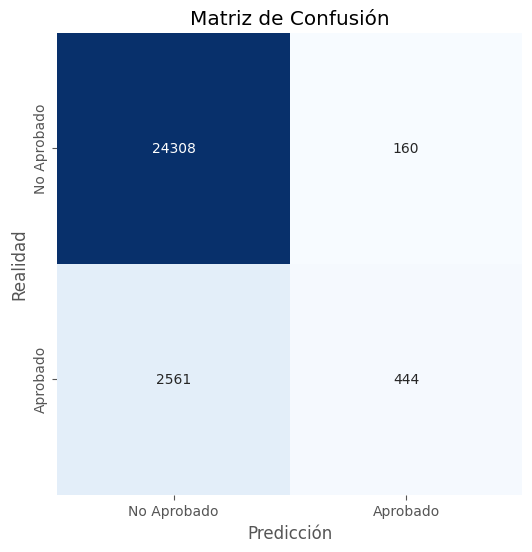

859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


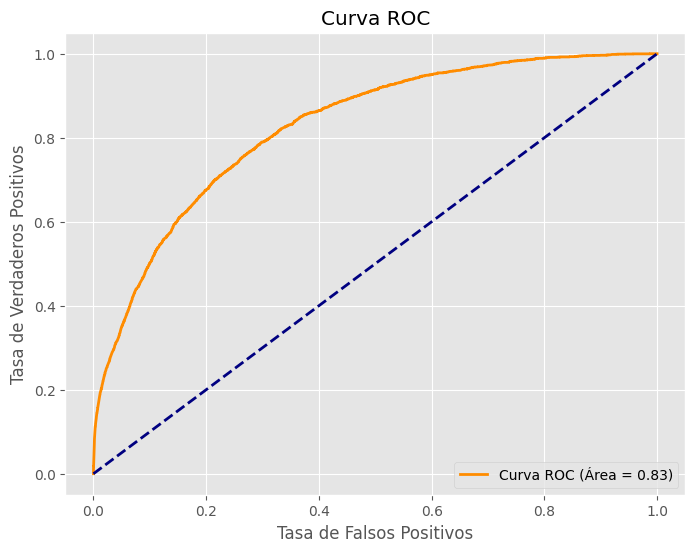

In [107]:
# Evaluación del modelo
print("Precisión del modelo:", accuracy_score(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Aprobado', 'Aprobado'], yticklabels=['No Aprobado', 'Aprobado'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (Área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

### OverSampling

In [108]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

# Supongamos que ya tienes tus datos cargados en df
# Separación de variables predictoras (X) y objetivo (y)
X = df[categorical_columns + numerical_columns]
y = (df['punt_global'] >= 300).astype(int)  # Objetivo binario

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar y codificar variables
scaler = StandardScaler()
encoder = OrdinalEncoder()

# Aplicar transformación a las variables de entrenamiento
X_train[categorical_columns] = encoder.fit_transform(X_train[categorical_columns])
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Aplicar transformación a las variables de prueba
X_test[categorical_columns] = encoder.transform(X_test[categorical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Definir SMOTE y UnderSampling
smote = SMOTE(sampling_strategy='minority', random_state=42)
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Crear un pipeline con SMOTE y UnderSampling
pipeline = Pipeline(steps=[('smote', smote), ('under', under), ('classifier', RandomForestClassifier(random_state=42))])

# Entrenamiento del modelo
pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de confusión:\n{conf_matrix}")

# AUC
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])  # Proporciona probabilidades para clase positiva
print(f"AUC: {roc_auc}")

              precision    recall  f1-score   support

           0       0.95      0.81      0.88     24468
           1       0.29      0.64      0.40      3005

    accuracy                           0.79     27473
   macro avg       0.62      0.72      0.64     27473
weighted avg       0.88      0.79      0.82     27473

Matriz de confusión:
[[19880  4588]
 [ 1091  1914]]
AUC: 0.8064701166955951


Precisión del modelo: 0.7932879554471663
Matriz de Confusión:
[[19880  4588]
 [ 1091  1914]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     24468
           1       0.29      0.64      0.40      3005

    accuracy                           0.79     27473
   macro avg       0.62      0.72      0.64     27473
weighted avg       0.88      0.79      0.82     27473



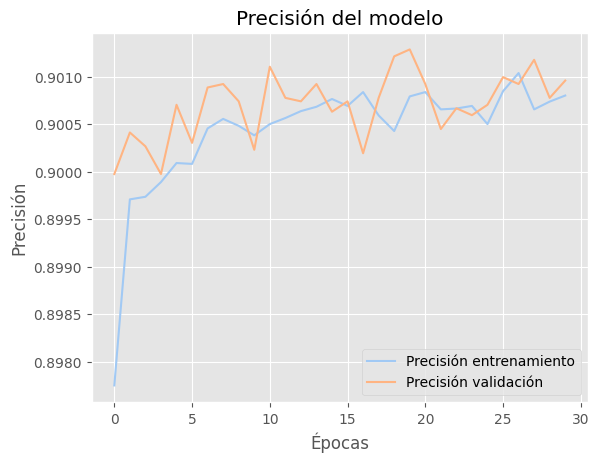

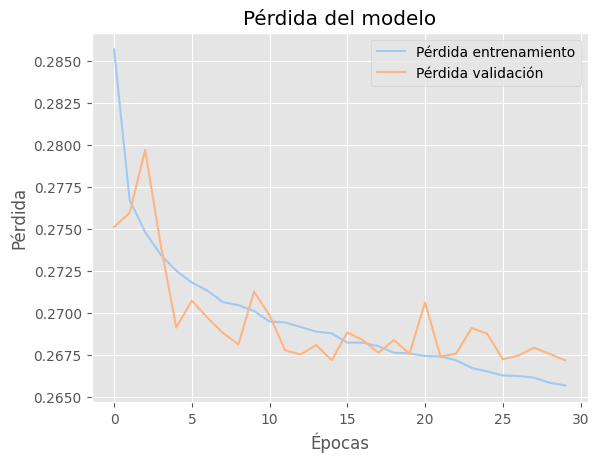

In [109]:
# Evaluación del modelo
print("Precisión del modelo:", accuracy_score(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Informe de clasificación
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred))

# Graficar la historia del entrenamiento
import matplotlib.pyplot as plt

# Graficar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Precisión del modelo: 0.7058930586393914


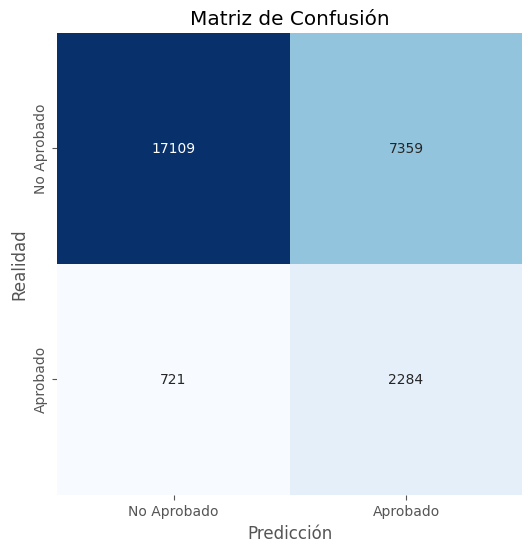

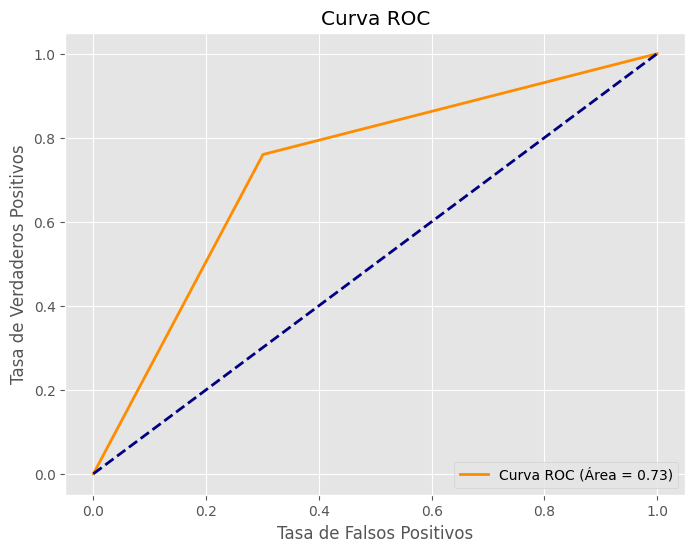

In [101]:
# Evaluación del modelo
print("Precisión del modelo:", accuracy_score(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Aprobado', 'Aprobado'], yticklabels=['No Aprobado', 'Aprobado'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (Área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

### UnderSampling

In [110]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Supongamos que ya tienes tus datos cargados en df
# Separación de variables predictoras (X) y objetivo (y)
X = df[categorical_columns + numerical_columns]
y = (df['punt_global'] >= 300).astype(int)  # Objetivo binario

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar y codificar variables
scaler = StandardScaler()
encoder = OrdinalEncoder()

# Aplicar transformación a las variables de entrenamiento
X_train[categorical_columns] = encoder.fit_transform(X_train[categorical_columns])
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Aplicar transformación a las variables de prueba
X_test[categorical_columns] = encoder.transform(X_test[categorical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Definir RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Aplicar UnderSampling en el conjunto de entrenamiento
X_train_res, y_train_res = under.fit_resample(X_train, y_train)

# Crear un modelo (en este caso, Random Forest)
model = RandomForestClassifier(random_state=42)

# Entrenamiento del modelo con los datos balanceados
model.fit(X_train_res, y_train_res)

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Evaluación del modelo:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de confusión:\n{conf_matrix}")

# AUC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])  # AUC utilizando las probabilidades para la clase positiva
print(f"AUC: {roc_auc}")

Evaluación del modelo:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     24468
           1       0.24      0.76      0.36      3005

    accuracy                           0.71     27473
   macro avg       0.60      0.73      0.59     27473
weighted avg       0.88      0.71      0.76     27473

Matriz de confusión:
[[17109  7359]
 [  721  2284]]
AUC: 0.8031358422029439


Precisión del modelo: 0.7058930586393914
Matriz de Confusión:
[[17109  7359]
 [  721  2284]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     24468
           1       0.24      0.76      0.36      3005

    accuracy                           0.71     27473
   macro avg       0.60      0.73      0.59     27473
weighted avg       0.88      0.71      0.76     27473



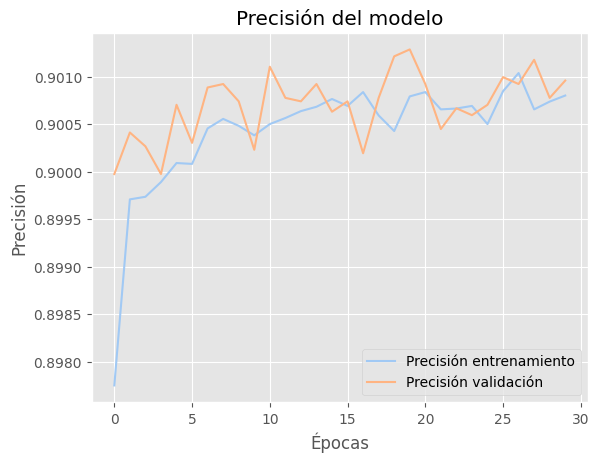

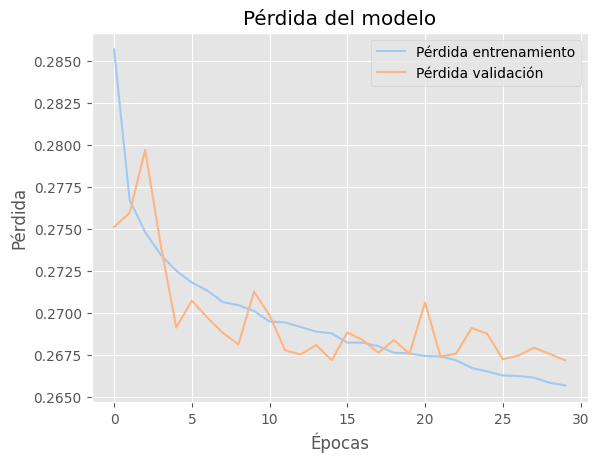

In [111]:
print("Precisión del modelo:", accuracy_score(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Informe de clasificación
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred))

# Graficar la historia del entrenamiento
import matplotlib.pyplot as plt

# Graficar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Precisión del modelo: 0.7058930586393914


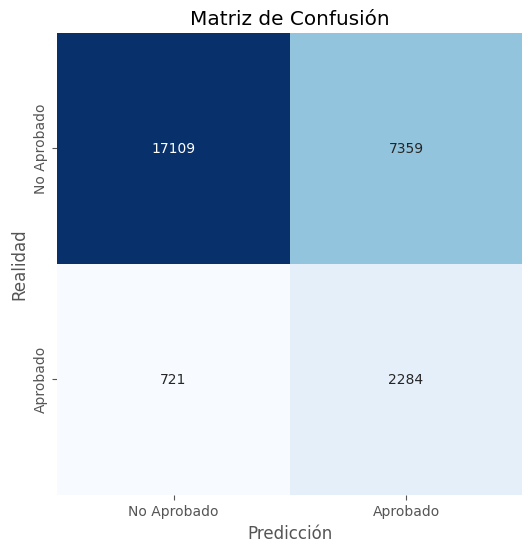

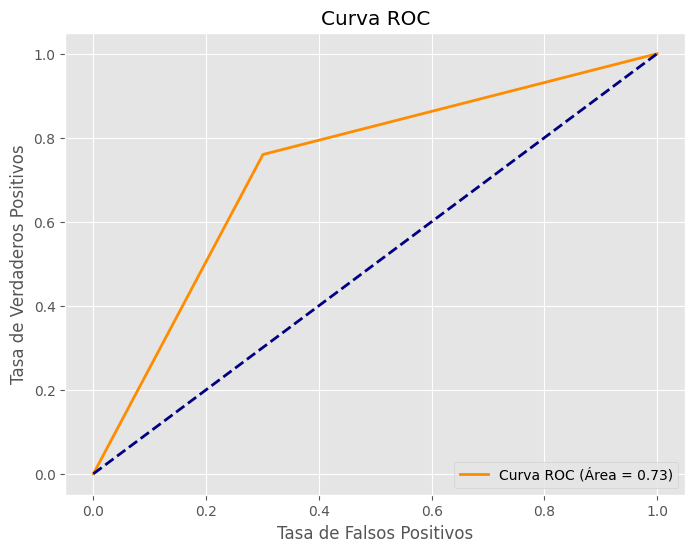

In [112]:
# Evaluación del modelo
print("Precisión del modelo:", accuracy_score(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Aprobado', 'Aprobado'], yticklabels=['No Aprobado', 'Aprobado'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (Área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

### Predicción

In [ ]:
# Definir un perfil con valores ajustados, incluyendo las columnas faltantes
perfil_alta_probabilidad = {
    'cole_area_ubicacion': 1,         # Zona urbana
    'cole_caracter': 1,               # Colegio de alto rendimiento
    'cole_bilingue': 1,               # Colegio bilingüe
    'cole_jornada': 0,                # Jornada completa
    'fami_tienecomputador': 1,        # Tiene computador
    'fami_tieneinternet': 1,          # Tiene internet
    'fami_tienelavadora': 1,          # Tiene lavadora
    'fami_tieneautomovil': 1,         # Tiene automóvil
    'edad_examen': 19.0,              # Edad estimada más madura
    'fami_estratovivienda': 6,        # Valor de ejemplo (puede ser el estrato socioeconómico)
    'fami_personashogar': 3           # Valor de ejemplo (número de personas en el hogar)
}

# Crear un DataFrame con estos datos
persona_df = pd.DataFrame([perfil_alta_probabilidad])

# Asegúrate de que las columnas numéricas estén presentes y normalizadas
persona_df[numerical_columns] = scaler.transform(persona_df[numerical_columns])

# Asegúrate de que el DataFrame esté en el mismo orden de columnas que en el entrenamiento
persona_df = persona_df[categorical_columns + numerical_columns]

# Realizar la predicción con el modelo
probabilidad = model.predict_proba(persona_df)[:, 1]  # Probabilidad de clase 1 (puntaje > 300)

# Imprimir la probabilidad
print(f"La probabilidad de que la persona tenga un puntaje mayor o igual a 300 es: {probabilidad[0]:.4f}")
